In [1]:
import json
import re
import sys
import warnings
from functools import lru_cache
from pathlib import Path
from copy import deepcopy

import aquarel
import ir_datasets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import trectools

import yaml
from scipy.stats import pearsonr, ttest_ind, ttest_rel
from tqdm import tqdm

sys.path.append("../..")
from set_encoder.data.ir_dataset_utils import DASHED_DATASET_MAP, get_base

In [2]:
theme = aquarel.Theme.from_file(Path.home() / "aquarel-theme.json")
theme.apply()
markers = ["o", "X", "s", "v", "P", "*", "D"]
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

In [3]:
BASELINE_DIR = Path("../../data/baseline-runs").resolve()
LOG_DIR = Path("../../experiments/set_encoder/wandb").resolve()

In [4]:
def parse_config(config_path):
    config = yaml.safe_load(config_path.read_text())

    flat_config = {}

    def flatten_config(config, prefix=""):
        for k, v in config.items():
            key = prefix + "." + k if prefix else k
            if isinstance(v, dict):
                if len(v) == 2 and "init_args" in v:
                    flat_config[key + f".class_path"] = v["class_path"]
                    flatten_config(v["init_args"], key)
                else:
                    flatten_config(v, key)
            else:
                flat_config[key] = v
        return config

    flatten_config(config)

    config = json.loads(
        (config_path.parent / "huggingface_checkpoint" / "config.json").read_text()
    )
    for k, v in config.items():
        flat_config[f"model.config.{k}"] = v

    for k, v in list(flat_config.items()):
        if isinstance(v, (list, tuple)):
            try:
                flat_config[k] = ".".join(_v for _v in v if _v)
            except:
                del flat_config[k]
        elif isinstance(v, dict):
            del flat_config[k]

    return flat_config


def load_run(run_file):
    if run_file.name.endswith(".run"):
        run = pd.read_csv(
            run_file,
            sep=r"\s+",
            header=None,
            names=["query_id", "Q0", "doc_id", "rank", "score", "run_name"],
        )
    # elif run_file.name.endswith(".jsonl"):
    #     run = pjson.read_json(run_file)
    #     run = run.to_pandas()
    #     # run = pd.read_json(run_file, lines=True)
    #     # run = run.drop(["query", "text", "original_query", "original_document"], axis=1)
    #     run = run.rename({"qid": "query_id", "docno": "doc_id"}, axis=1)
    #     run["run_name"] = run_file.parent.name
    #     run["Q0"] = "Q0"
    else:
        raise ValueError(f"Unknown run file type: {run_file}")
    if run.empty:
        return None, {}
    if "tirex" in str(run_file):
        first_stage = "tirex"
        run["run_name"] = run_file.parent.name
    else:
        first_stage = run_file.parent.name
    run = run.sort_values(["query_id", "score"], ascending=[True, False])
    run["rank"] = run.groupby("query_id")["score"].rank(ascending=False, method="first")
    config = {}
    config_path = run_file.parent.parent.parent.parent / "pl_config.yaml"
    if config_path.exists() and "wandb" in str(run_file):
        run_id = run_file.parent.parent.parent.parent.parent.name.split("-")[-1]
        config = parse_config(config_path)
        run["run_name"] = run_id
    if "rank-gpt" in str(run_file):
        run["run_name"] = run_file.parent.name
    # if arguana or quora, remove queries from run
    # https://twitter.com/nandan__thakur/status/1603920955679551488
    # https://github.com/beir-cellar/beir/blob/bc4d2b50b0059c0895282b609ff30b0530ed6648/beir/retrieval/evaluation.py#L49
    dataset_name = run_file.name.split(".")[0]
    dataset_name = re.sub(r"__.+__", "", dataset_name)
    depth = 100
    try:
        dataset_id = DASHED_DATASET_MAP[dataset_name]
    except KeyError:
        split = dataset_name.split("_")
        if len(split) == 2:
            first_stage, dataset_name = split
        elif len(split) == 3:
            first_stage, depth, dataset_name = split
            depth = int(depth)
        else:
            raise ValueError(f"Unknown dataset name: {dataset_name}")
        if "tirex" in first_stage:
            first_stage = "tirex"
        dataset_id = DASHED_DATASET_MAP[dataset_name]
    if dataset_id.startswith("beir/arguana") or dataset_id.startswith("beir/quora"):
        qids = pd.DataFrame(ir_datasets.load(dataset_id).queries_iter())["query_id"]
        run = run.loc[~run["doc_id"].isin(qids)]
    run["rank"] = (
        run.groupby("query_id")["score"]
        .rank(ascending=False, method="first")
        .astype(int)
    )
    config["dataset"] = dataset_id
    config["first_stage"] = first_stage
    config["depth"] = int(depth)
    config["base"] = get_base(dataset_id)
    if "medline" in config["base"]:
        config["base"] = "medline"
    config["run_name"] = run.iloc[0]["run_name"]
    if "bm25" in config["run_name"].lower():
        config["run_name"] = "bm25"
    if "colbert" in config["run_name"].lower():
        config["run_name"] = "colbert"
    if "chatnoir" in config["run_name"].lower():
        config["run_name"] = "bm25"
    run = run.astype({"query_id": str, "doc_id": str})
    return run, config


@lru_cache
def load_qrels(dataset):
    qrels = trectools.TrecQrel()
    dataset = ir_datasets.load(dataset)
    qrels_df = pd.DataFrame(dataset.qrels_iter())
    qrels_df = qrels_df.rename(
        {"query_id": "query", "doc_id": "docid", "relevance": "rel", "iteration": "q0"},
        axis=1,
    )
    qrels.qrels_data = qrels_df
    return qrels


def evaluate_run(run_df, qrels, baseline_df, metrics):
    metric_to_func = {
        "NDCG": "get_ndcg",
        "rNDCG": "get_ndcg",
        "MRR": "get_reciprocal_rank",
        "UNJ": "get_unjudged",
    }
    run_df = run_df.rename(
        {"query_id": "query", "Q0": "q0", "doc_id": "docid", "run_name": "system"},
        axis=1,
    )
    run = trectools.TrecRun()
    run.run_data = run_df
    trec_eval = trectools.TrecEval(run, qrels)
    metric_dfs = []
    for full_metric, kwargs in metrics.items():
        metric, depth = full_metric.split("@")
        depth = depth.split("_")[0]
        depth = int(depth)
        func_name = metric_to_func[metric]
        old_qrels = deepcopy(trec_eval.qrels.qrels_data)
        if full_metric.startswith("rNDCG"):
            qrels_data = trec_eval.qrels.qrels_data.merge(
                baseline_df.loc[:, ["query_id", "doc_id"]],
                how="inner",
                left_on=["query", "docid"],
                right_on=["query_id", "doc_id"]
            )
            trec_eval.qrels.qrels_data = qrels_data
        func = getattr(trec_eval, func_name)
        values = func(depth, per_query=True, **kwargs)
        if full_metric.startswith("rNDCG"):
            trec_eval.qrels.qrels_data = old_qrels
        values = values.rename(lambda x: full_metric, axis=1)
        metric_dfs.append(values.fillna(0))
    metric_df = pd.concat(metric_dfs, axis=1)
    return metric_df


def concat_df_config(df, config):
    length = df.shape[1] + len(config)
    values = np.empty((df.shape[0], length), dtype="object")
    values[:, : df.shape[1]] = df.values
    values[:, df.shape[1] :] = np.array(list(config.values()))
    columns = list(df.columns) + list(config.keys())
    return pd.DataFrame(values, columns=columns).astype({"depth": int})

In [9]:
baseline_runs = {}
for run_file in tqdm(
    list(BASELINE_DIR.glob("bm25/*.run"))
    + list(BASELINE_DIR.glob("tirex/bm25/*.run"))
    + list(BASELINE_DIR.glob("*-ideal/*.run"))
    + list(BASELINE_DIR.glob("*-random/*.run"))
    + list(BASELINE_DIR.glob("tirex/chatnoir/*.run"))
    + list(BASELINE_DIR.glob("colbert/*.run"))
):
    if (
        "tripclick" in run_file.name
        or "beir" in run_file.name
        # or "tirex" in str(run_file)
        or "dev" in str(run_file)
        or "orcas" in run_file.name
        or "train" in run_file.name
        or ("dev" in run_file.name and "small" not in run_file.name)
        or run_file.name.startswith("__")
    ):
        continue
    run, _ = load_run(run_file)
    if run is None:
        continue
    key = run_file.parent.name
    if "tirex" in str(run_file):
        key = "tirex"
    key = (key, run_file.stem)
    baseline_runs[key] = run

100%|██████████| 122/122 [00:04<00:00, 24.94it/s]


In [6]:
depth = 100
metrics = {
    "NDCG@10": {},
    # "rNDCG@10": {},
    # "NDCG@10_UNJ" : {"removeUnjudged": True},
    # f"MRR@{depth}": {},
    # "UNJ@10": {},
}

In [13]:
# trectools throws annoying warnings because of pandas
warnings.simplefilter(action="ignore", category=FutureWarning)
per_query_dfs = []

run_files = (
    list(BASELINE_DIR.glob("bm25/*.run"))
    + list(BASELINE_DIR.glob("tirex/*/*.run"))
    + list(BASELINE_DIR.glob("*-case/*.run"))
    + list(BASELINE_DIR.glob("colbert/*.run"))
    + list(BASELINE_DIR.glob("rank-gpt-*/*.run"))
    + list(LOG_DIR.glob("**/*.run"))
)

pg = tqdm(run_files)
for run_file in pg:
    if not run_file.exists():
        continue
    if run_file.name.endswith(".jsonl.gz"):
        continue
    if (
        "tripclick" in run_file.name
        or "beir" in run_file.name
        # or "tirex" in str(run_file)
        or "dev" in str(run_file)
        or "orcas" in run_file.name
        or "train" in run_file.name
        or ("dev" in run_file.name and "small" not in run_file.name)
        or run_file.name.startswith("__")
    ):
        continue
    pg.set_description(run_file.name)
    run_df, config = load_run(run_file)
    # if run_df is None:
    #     continue
    qrels = load_qrels(config["dataset"])
    qrel_qids = set(qrels.qrels_data["query"])
    run_qids = set(run_df["query_id"].drop_duplicates())
    missing_qids = set(qrel_qids) - set(run_qids)
    if missing_qids:
        print(f"found {len(missing_qids)} missing qids in {run_file}")
        qrels_df = qrels.qrels_data.loc[qrels.qrels_data["query"].isin(run_qids)]
        qrels.qrels_data = qrels_df
    baseline_df = baseline_runs.get(
        (config["first_stage"], run_file.stem.split("_")[-1])
    )
    baseline_df = baseline_df.loc[baseline_df["rank"] <= config["depth"]]
    metric_df = evaluate_run(run_df, qrels, baseline_df, metrics)
    eval_df = concat_df_config(metric_df.reset_index().astype({"query": str}), config)
    per_query_dfs.append(eval_df)

per_query_results = pd.concat(per_query_dfs).infer_objects().reset_index(drop=True)

# per_query_results = per_query_results.loc[
#     ~(
#         per_query_results["first_stage"].str.contains("tirex")
#         & per_query_results["dataset"].str.contains("msmarco")
#     )
# ]

del per_query_dfs

per_query_results["finetuned"] = per_query_results[
    "model.model_name_or_path"
].str.contains("experiments")


def fix_model_path(x):
    model_name = str(x.iloc[0])
    if "experiments" in model_name:
        run_name = model_name.split("/")[3].split("-")[-1]
        new_model_name = per_query_results.loc[
            per_query_results["run_name"] == run_name, "model.model_name_or_path"
        ].iloc[0]
        return pd.Series(new_model_name, index=x.index)
    return x


per_query_results["model.model_name_or_path"] = per_query_results.groupby("run_name")[
    "model.model_name_or_path"
].transform(fix_model_path)


per_query_results.loc[
    per_query_results["dataset"].str.contains("cqadupstack"), "dataset"
] = "beir/cqadupstack"
per_query_results.loc[
    per_query_results["dataset"].str.contains("cqadupstack"), "base"
] = "beir-cqadupstack"

per_query_results.reset_index(drop=True).to_json("set_encoder_per_query_results.json")

msmarco-document-trec-dl-2020-judged.run:   1%|          | 16/1439 [00:00<00:11, 127.63it/s]

colbert_10_msmarco-passage-trec-dl-2019-judged.run: 100%|██████████| 1439/1439 [01:42<00:00, 13.97it/s]           


In [20]:
per_query_results = pd.read_json("set_encoder_per_query_results.json")

In [14]:
def run_type(row):
    if row["model.other_doc_attention"] and not pd.isna(
        row["model.other_doc_attention"]
    ):
        if row["model.rank_position_embeddings"] == "sorted":
            return "Set-Encoder (+Rank)"
        return "Set-Encoder"
    if not pd.isna(row["model.model_name_or_path"]):
        return "monoELECTRA"
    if "rank-gpt" in row["run_name"]:
        if "turbo" in row["run_name"]:
            return "RankGPT-4 Turbo"
        return "RankGPT-4"
    if "monot5" in row["run_name"]:
        return row["run_name"].replace("t5", "T5").replace("-", " ")
    if "monobert" in row["run_name"]:
        return row["run_name"].replace("bert", "BERT").replace("-", " ")
    if "sparse" in row["run_name"]:
        return "Sparse monoMiniLM"
    if "list-in-t5" in row["run_name"]:
        return "LiT5-Distill"
    return "First Stage"


def num_params(row):
    if "monot5-base" in row["run_name"]:
        return "220M"
    if "monot5-large" in row["run_name"]:
        return "770M"
    if "monot5-3b" in row["run_name"]:
        return "3B"
    if "rank-gpt-4" in row["run_name"]:
        return "?"
    if "list-in-t5" in row["run_name"]:
        return "220M"
    if "sparse" in row["run_name"]:
        return "11M"
    if "monobert-base" in row["run_name"]:
        return "110M"
    if "monobert-large" in row["run_name"]:
        return "340M"
    if (
        not pd.isna(row["model.model_name_or_path"])
        and "electra-base" in row["model.model_name_or_path"]
    ):
        return "110M"
    if (
        not pd.isna(row["model.model_name_or_path"])
        and "electra-large" in row["model.model_name_or_path"]
    ):
        return "340M"
    return "--"


def first_train_dataset(row):
    if pd.isna(row["data.train_ir_dataset_paths"]):
        return None
    if row["finetuned"]:
        return "CBv2"
    if "rank-gpt-3-turbo" in row["data.train_ir_dataset_paths"]:
        return "RGPT3.5"
    if "rank-gpt-4-turbo" in row["data.train_ir_dataset_paths"]:
        return "RGPT4-T"
    if "msmarco-passage-train" in row["data.train_ir_dataset_paths"]:
        return "CBv2"
    return None


def second_train_dataset(row):
    if pd.isna(row["data.train_ir_dataset_paths"]):
        return None
    if row["first_train_dataset"] != "CBv2":
        return None
    if "rank-gpt-3-turbo" in row["data.train_ir_dataset_paths"]:
        return "RGPT3.5"
    if "rank-gpt-4-turbo" in row["data.train_ir_dataset_paths"]:
        return "RGPT4-T"
    if (
        "msmarco-passage-train" in row["data.train_ir_dataset_paths"]
        and row["finetuned"]
    ):
        return "CBv2"
    return None


per_query_results["run_type"] = per_query_results.apply(run_type, axis=1)
per_query_results["first_train_dataset"] = per_query_results.apply(
    first_train_dataset, axis=1
)
per_query_results["second_train_dataset"] = per_query_results.apply(
    second_train_dataset, axis=1
)
per_query_results["num_params"] = per_query_results.apply(num_params, axis=1)

warnings.simplefilter(action="ignore", category=pd.errors.PerformanceWarning)
groupby_columns = list(
    filter(lambda x: x not in list(metrics) + ["query"], per_query_results.columns)
)
results = (
    per_query_results.groupby(groupby_columns, dropna=False)[list(metrics)]
    .mean()
    .reset_index()
    .copy()
)
groupby_columns = list(
    filter(
        lambda x: x not in list(metrics) + ["dataset", "query"],
        per_query_results.columns,
    )
)
base_results = (
    results.groupby(groupby_columns, dropna=False)[list(metrics)]
    .mean()
    .reset_index()
    .copy()
)
base_results

,first_stage,depth,base,run_name,seed_everything,trainer.accelerator,trainer.strategy,trainer.devices,trainer.num_nodes,trainer.precision,...,model.config.label2id,model.loss_function.discounted,model.loss_function.temperature,model.loss_function.scale_gains,finetuned,run_type,first_train_dataset,second_train_dataset,num_params,NDCG@10
0,bm25,10,msmarco-passage,0ekczhdc,42.0,auto,auto,auto,1.0,bf16-mixed,...,NaN,True,NaN,NaN,True,monoELECTRA,CBv2,RGPT4-T,110M,0.542002
1,bm25,10,msmarco-passage,1ck3bk8c,42.0,auto,auto,auto,1.0,bf16-mixed,...,NaN,True,NaN,NaN,True,Set-Encoder,CBv2,RGPT4-T,110M,0.544622
2,bm25,10,msmarco-passage,1dtad447,42.0,auto,auto,auto,1.0,bf16-mixed,...,NaN,NaN,NaN,NaN,True,Set-Encoder,CBv2,CBv2,110M,0.534146
3,bm25,10,msmarco-passage,6eqec2jo,42.0,auto,auto,auto,1.0,bf16-mixed,...,NaN,NaN,NaN,NaN,True,Set-Encoder,CBv2,CBv2,110M,0.538605
4,bm25,10,msmarco-passage,6z1l5dg1,42.0,auto,auto,auto,1.0,bf16-mixed,...,NaN,True,NaN,NaN,True,Set-Encoder,CBv2,RGPT4-T,110M,0.543988
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
563,tirex,100,wapo-v2,sparse-cross-encoder-4-4096,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,Sparse monoMiniLM,NaN,NaN,11M,0.295565
564,tirex,100,wapo-v2,sparse-cross-encoder-4-512,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,Sparse monoMiniLM,NaN,NaN,11M,0.433853
565,tirex,100,wapo-v2,u6029rkf,42.0,auto,auto,auto,1.0,bf16-mixed,...,NaN,True,NaN,NaN,False,Set-Encoder,RGPT4-T,NaN,110M,0.361515
566,tirex,100,wapo-v2,weeue9ai,42.0,auto,auto,auto,1.0,bf16-mixed,...,NaN,True,NaN,NaN,True,monoELECTRA,CBv2,RGPT3.5,110M,0.449944


In [9]:
def format_column(series):
    rounded = series.round(3)
    first, second, *_ = sorted(set(rounded.dropna()), reverse=True)
    out_values = []
    for val in rounded:
        if pd.isna(val):
            out_val = "--"
        else:
            out_val = f"{val:.3f}"
        if val == first:
            out_val = "\\textbf{" + out_val + "}"
        if val == second:
            out_val = "\\underline{" + out_val + "}"
        out_values.append(out_val)
    out = pd.Series(out_values, index=series.index)
    return out

def compute_significance(df, metric):
    from itertools import combinations

    per_query_df = per_query_results.set_index(df.columns.names + df.index.names)[
        metric
    ]
    num_rows = len(df.index)
    num_columns = len(df.columns)
    letters = "abcdefghijklmnopqrstuvwxyz"
    results = [[[] for _ in range(num_columns)] for _ in range(num_rows)]
    p = 0.05 / (num_rows * num_columns * (num_rows - 1))
    print(p)
    for column_idx, column in enumerate(df.columns):
        if not isinstance(column, tuple):
            column = (column,)
        for (idx_a, idx_b), (approach_a, approach_b) in zip(
            combinations(range(len(df.index)), 2), combinations(df.index, 2)
        ):
            run_a = per_query_df.loc[column + approach_a]
            run_b = per_query_df.loc[column + approach_b]
            assert len(run_a) == len(run_b)
            p_value = ttest_rel(run_a.values, run_b.values)[1]
            if p_value < p:
                results[idx_a][column_idx].append(letters[idx_b])
                results[idx_b][column_idx].append(letters[idx_a])
    return results

In [10]:
index_columns = [
    "run_type",
    # "num_params",
    "first_train_dataset",
    "second_train_dataset",
    "data.train_sample_size",
    "run_name",
]
values = ["NDCG@10"]

filter_series = (
    ~(results["num_params"].isin(["340M"]) & results["run_type"].isin(["Set-Encoder"]))
    & ~results["model.loss_function.class_path"].str.contains("Approx").fillna(False)
    & results["depth"].isin([100])
    & (
        results["data.train_sample_size"].isna()
        | results["data.train_sample_size"].isin([8, 20, 100])
    )
    & ~results["first_stage"].isin(["bm25", "worst-case", "best-case", "random-case"])
    & ~results["run_name"].str.contains("4096")
    # & ~results["run_type"].str.contains("\+Rank")
    & results["base"].str.contains("msmarco")
    & results["run_type"].isin(
        [
            "Set-Encoder",
            "monoELECTRA",
            "LiT5-Distill",
            "First Stage",
            "RankGPT-4",
            "RankGPT-4 Turbo",
        ]
    )
)

table = (
    results.loc[filter_series]
    .pivot(
        index=index_columns,
        columns=["first_stage", "dataset"],
        values=values,
    )
    .droplevel(axis=1, level=0)
)
# tirex = table.loc[:, ["tirex"]].mean(axis=1, skipna=False).to_frame()
# tirex.columns = pd.MultiIndex.from_tuples([("tirex", "Average")])
# table = pd.concat([table, tirex], axis=1)

table = table.apply(format_column, axis=0)
models = [
    "First Stage",
    "RankGPT-4",
    "RankGPT-4 Turbo",
    "LiT5-Distill",
    "monoELECTRA",
    "Set-Encoder",
]
stages = [
    "CBv2",
    "RGPT3.5",
    "RGPT4 Turbo",
]
index_order_dict = {
    np.nan: 0,
    **{model: i + 1 for i, model in enumerate(models)},
    **{stage: i + 1 for i, stage in enumerate(stages)},
}

column_order_dict = {"tirex": 0, "colbert": 1}

columns_map = {
    "msmarco-passage/trec-dl-2019/judged": "TREC DL 19",
    "msmarco-passage/trec-dl-2020/judged": "TREC DL 20",
    "tirex": "BM25",
    "colbert": "ColBERTv2",
}


def order(x, order_dict):
    return x.map(order_dict)


table = table.sort_index(key=lambda x: order(x, index_order_dict))
table = table.sort_index(key=lambda x: order(x, column_order_dict), axis=1)
table = table.rename(columns_map, axis=1)
table

first_stage                                                                                                            BM25  \
dataset                                                                                                          TREC DL 19   
run_type        first_train_dataset second_train_dataset data.train_sample_size run_name                                      
First Stage     NaN                 NaN                  NaN                    bm25                                  0.480   
                                                                                colbert                                  --   
RankGPT-4       NaN                 NaN                  NaN                    rank-gpt-4                            0.713   
RankGPT-4 Turbo NaN                 NaN                  NaN                    rank-gpt-4-turbo                      0.716   
LiT5-Distill    NaN                 NaN                  NaN                    castorini-list-in-t5-300              0.696   
monoELECTRA     CBv2                NaN                  8.0                    miiol19k                              0.668   
                                    CBv2                 100.0                  hg4iejrx                              0.677   
                                    RGPT3.5              20.0                   weeue9ai                              0.697   
                                    RGPT4-T              100.0                  gl9bq8ip                     \textbf{0.730}   
                RGPT3.5             NaN                  20.0                   eh9y6w01                              0.695   
                RGPT4-T             NaN                  100.0                  ntiekn1k                              0.681   
Set-Encoder     CBv2                NaN                  8.0                    rvdznqla                              0.633   
                                    CBv2                 100.0                  x7lfs6zv                              0.668   
                                    RGPT3.5              20.0                   1d2fa07r                              0.691   
                                    RGPT4-T              100.0                  e8bypanb                  \underline{0.725}   
                RGPT3.5             NaN                  20.0                   r9jwo57q                              0.676   
                RGPT4-T             NaN                  100.0                  u6029rkf                              0.672   

first_stage                                                                                                                  \
dataset                                                                                                          TREC DL 20   
run_type        first_train_dataset second_train_dataset data.train_sample_size run_name                                      
First Stage     NaN                 NaN                  NaN                    bm25                                  0.494   
                                                                                colbert                                  --   
RankGPT-4       NaN                 NaN                  NaN                    rank-gpt-4                   \textbf{0.713}   
RankGPT-4 Turbo NaN                 NaN                  NaN                    rank-gpt-4-turbo                      0.699   
LiT5-Distill    NaN                 NaN                  NaN                    castorini-list-in-t5-300              0.679   
monoELECTRA     CBv2                NaN                  8.0                    miiol19k                              0.681   
                                    CBv2                 100.0                  hg4iejrx                              0.685   
                                    RGPT3.5              20.0                   weeue9ai                              0.689   
                                    RGPT4-T              100.0

In [12]:
print(
    table.to_latex(na_rep="--", multirow=False)
    .replace("_", "-")
    .replace(".000000", "")
)

\begin{tabular}{lllllllll}
\toprule
 &  &  &  & first-stage & \multicolumn{2}{r}{BM25} & \multicolumn{2}{r}{ColBERTv2} \\
 &  &  &  & dataset & TREC DL 19 & TREC DL 20 & TREC DL 19 & TREC DL 20 \\
run-type & first-train-dataset & second-train-dataset & data.train-sample-size & run-name &  &  &  &  \\
\midrule
First Stage & -- & -- & -- & bm25 & 0.480 & 0.494 & -- & -- \\
 &  &  &  & colbert & -- & -- & 0.732 & 0.725 \\
RankGPT-4 & -- & -- & -- & rank-gpt-4 & 0.713 & \textbf{0.713} & 0.766 & \textbf{0.793} \\
RankGPT-4.5 & -- & -- & -- & rank-gpt-4-turbo & 0.716 & 0.699 & \textbf{0.777} & \underline{0.764} \\
LiT5-Distill & -- & -- & -- & castorini-list-in-t5-300 & 0.696 & 0.679 & 0.753 & 0.744 \\
monoELECTRA & CBv2 & -- & 8 & miiol19k & 0.668 & 0.681 & 0.760 & 0.746 \\
 &  & CBv2 & 100 & hg4iejrx & 0.677 & 0.685 & 0.757 & 0.739 \\
 &  & RGPT3.5 & 20 & weeue9ai & 0.697 & 0.689 & 0.757 & 0.740 \\
 &  & RGPT4.5 & 100 & gl9bq8ip & \textbf{0.730} & \underline{0.710} & 0.769 & 0.762 \\
 & RG

In [13]:
index_columns = [
    "run_type",
    "num_params",
]
values = ["NDCG@10"]


filter_series = (
    (
        ~base_results["run_type"].isin(["Set-Encoder", "monoELECTRA"])
        | (
            base_results["second_train_dataset"].isin(["RGPT4.5"])
            & base_results["num_params"].isin(["110M"])
        )
    )
    & ~base_results["run_type"].str.contains("RankGPT")
    & ~base_results["model.loss_function.class_path"]
    .str.contains("Approx")
    .fillna(False)
    & base_results["depth"].isin([100])
    & (
        base_results["data.train_sample_size"].isna()
        | base_results["data.train_sample_size"].isin([8, 20, 100])
    )
    & base_results["first_stage"].isin(["tirex"])
    & ~base_results["run_name"].str.contains("4096")
    & ~base_results["run_type"].str.contains("\+Rank")
)

table = base_results.loc[filter_series].pivot(
    index=index_columns + ["run_name"],
    columns=["first_stage", "base"],
    values=values,
)
table = table.droplevel(axis=1, level=0)
sig = compute_significance(table.loc[["monoELECTRA","Set-Encoder"]], "NDCG@10")
table = table.droplevel(axis=1, level=0).droplevel(axis=0, level=-1)


def hmean(x):
    return 1 / np.mean(1 / x)


def qmean(x):
    return np.sqrt(np.mean(x**2))


def gmean(x):
    return np.exp(np.log(x.prod()) / x.notna().sum(1))


arithmetic_mean = table.mean(axis=1).rename("Arithmetic Mean").to_frame()
harmonic_mean = table.apply(hmean, axis=1).rename("Harmonic Mean").to_frame()
quadratic_mean = table.apply(qmean, axis=1).rename("Quadratic Mean").to_frame()
geoemtric_mean = table.apply(qmean, axis=1).rename("Geometric Mean").to_frame()

table = pd.concat(
    [
        table,
        arithmetic_mean,
        # harmonic_mean,
        # quadratic_mean,
        geoemtric_mean,
    ],
    axis=1,
)

table = table.apply(format_column, axis=0)
models = [
    "First Stage",
    "Sparse monoMiniLM",
    "monoBERT base",
    "monoBERT large",
    "monoT5 base",
    "monoT5 large",
    "monoT5 3b",
    "LiT5-Distill",
    "RankGPT-4",
    "RankGPT-4.5",
    "monoELECTRA",
    "Set-Encoder",
]
stages = [
    "CBv2",
    "RGPT3.5",
    "RGPT4.5",
]
index_order_dict = {
    np.nan: 0,
    **{model: i + 1 for i, model in enumerate(models)},
    **{stage: i + 1 for i, stage in enumerate(stages)},
}

base_map = {
    "antique": "Antique",
    "argsme-2020-04-01": "Args.me",
    "clueweb09": "ClueWeb09",
    "clueweb12": "ClueWeb12",
    "cord19": "CORD-19",
    "cranfield": "Cranfield",
    "disks45-nocr": "Disks4+5",
    "gov": "GOV",
    "gov2": "GOV2",
    "medline": "MEDLINE",
    "msmarco-passage": "MS~MARCO",
    "nfcorpus": "NFCorpus",
    "vaswani": "Vaswani",
    "wapo-v2": "WaPo",
}


def order(x, order_dict):
    return x.map(order_dict)


table = table.sort_index(key=lambda x: order(x, index_order_dict))
table = table.rename(base_map, axis=1)
table

0.0017857142857142859


,,Antique,Args.me,ClueWeb09,ClueWeb12,CORD-19,Cranfield,Disks4+5,GOV,GOV2,MEDLINE,MS~MARCO,NFCorpus,Vaswani,WaPo,Arithmetic Mean,Geometric Mean
run_type,num_params,,,,,,,,,,,,,,,,
First Stage,--,0.516,\underline{0.404},0.178,\textbf{0.364},0.586,\underline{0.012},0.436,0.237,0.466,0.358,0.487,0.281,0.447,0.364,0.367,0.394
Sparse monoMiniLM,11M,0.545,0.312,0.198,\underline{0.312},0.673,\textbf{0.014},0.498,0.267,0.502,0.228,0.691,0.299,0.436,0.434,0.386,0.427
monoBERT base,110M,0.512,0.314,0.192,0.263,\textbf{0.690},0.009,0.531,0.265,0.489,0.256,0.701,0.310,0.321,0.449,0.379,0.422
monoBERT large,340M,0.489,0.371,0.134,0.251,0.625,0.009,0.504,0.250,0.474,0.296,0.714,0.303,0.476,0.438,0.381,0.422
monoT5 base,220M,0.510,0.304,0.186,0.260,\underline{0.688},0.009,0.535,0.267,0.486,0.253,0.705,0.310,0.306,0.451,0.376,0.420
monoT5 large,770M,0.532,0.337,0.182,0.266,0.636,0.010,\underline{0.566},0.267,0.512,0.313,0.717,\underline{0.311},0.414,\textbf{0.492},0.397,0.438
monoT5 3b,3B,0.543,0.391,\underline{0.201},0.279,0.603,0.011,\textbf{0.569},\textbf{0.292},0.513,0.348,\textbf{0.736},\textbf{0.324},0.458,\underline{0.476},\textbf{0.410},\textbf{0.448}
LiT5-Distill,220M,\textbf{0.576},0.394,\textbf{0.215},0.275,0.686,0.011,0.509,\underline{0.268},\textbf{0.534},0.334,0.687,0.293,0.429,0.470,\underline{0.406},0.445
monoELECTRA,110M,0.539,0.379,0.174,0.288,0.674,0.008,0.460,0.229,0.513,\underline{0.366},\underline{0.720},0.280,\underline{0.482},0.435,0.396,0.438


In [14]:
for idx, val in enumerate(sig[0]):
    print(idx + 1, table.columns[idx], val)

1 Antique ['b']
2 Args.me ['b']
3 ClueWeb09 []
4 ClueWeb12 []
5 CORD-19 []
6 Cranfield []
7 Disks4+5 []
8 GOV ['b']
9 GOV2 []
10 MEDLINE []
11 MS~MARCO []
12 NFCorpus []
13 Vaswani []
14 WaPo []


In [46]:
print(
    table.to_latex(na_rep="--", multirow=False)
    .replace("_", "-")
    .replace(".000000", "")
)

\begin{tabular}{llllllllllllllllll}
\toprule
 &  & Antique & Args.me & ClueWeb09 & ClueWeb12 & CORD-19 & Cranfield & Disks4+5 & GOV & GOV2 & MEDLINE & MS~MARCO & NFCorpus & Vaswani & WaPo & Arithmetic Mean & Geometric Mean \\
run-type & num-params &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  \\
\midrule
First Stage & -- & 0.516 & \underline{0.404} & 0.178 & \textbf{0.364} & 0.586 & \underline{0.012} & 0.436 & 0.237 & 0.466 & 0.358 & 0.487 & 0.281 & 0.447 & 0.364 & 0.367 & 0.394 \\
Sparse monoMiniLM & 11M & 0.545 & 0.312 & 0.198 & \underline{0.312} & 0.673 & \textbf{0.014} & 0.498 & 0.267 & 0.502 & 0.228 & 0.691 & 0.299 & 0.436 & 0.434 & 0.386 & 0.427 \\
monoBERT base & 110M & 0.512 & 0.314 & 0.192 & 0.263 & \textbf{0.690} & 0.009 & 0.531 & 0.265 & 0.489 & 0.256 & 0.701 & 0.310 & 0.321 & 0.449 & 0.379 & 0.422 \\
monoBERT large & 340M & 0.489 & 0.371 & 0.134 & 0.251 & 0.625 & 0.009 & 0.504 & 0.250 & 0.474 & 0.296 & 0.714 & 0.303 & 0.476 & 0.438 & 0.381 & 0.422 \\
monoT5 base & 220M & 

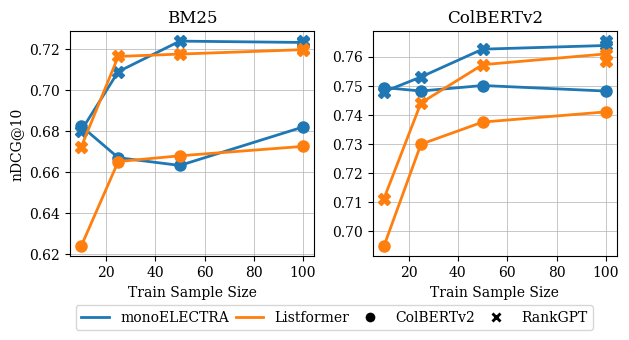

In [47]:
index_columns = [
    "run_type",
    # "num_params",
    "first_train_dataset",
    "second_train_dataset",
    "data.train_sample_size",
    "depth",
    "run_name",
]
values = ["NDCG@10"]

filter_series = ~base_results["num_params"].isin(["330M"]) & ~base_results[
    "model.loss_function.class_path"
].str.contains("ApproxNDCG").fillna(False)

df = (
    base_results.loc[base_results["base"].isin(["msmarco-passage"]) & filter_series]
    .pivot(
        index=index_columns,
        columns=["first_stage"],
        values=values,
    )
    .droplevel(axis=1, level=0)
)

scale = 0.8
# fig, axs = plt.subplots(1, 4, figsize=(16 * scale, 4 * scale))
fig, axs = plt.subplots(1, 2, figsize=(8 * scale, 4 * scale))

for stage_idx, first_stage in enumerate(["bm25", "colbert"]):
    baseline = df.loc[pd.IndexSlice[:, :, :, :, :, first_stage]].dropna(axis=1)
    assert baseline.shape[0] == 1 and baseline.shape[1] == 1
    for model_idx, model in enumerate(("monoELECTRA", "Set-Encoder")):
        for second_idx, second in enumerate(("ColBERTv2", "ColBERTv2 + RankGPT-4.5")):
            model_df = df.loc[pd.IndexSlice[model, :, second], first_stage].copy()
            # for aligned_idx, aligned in enumerate((True, False)):
            for aligned_idx, aligned in enumerate([False]):
                reset = model_df.reset_index()
                if aligned:
                    valid = reset["depth"] == reset["data.train_sample_size"]
                else:
                    valid = reset["depth"] == 100
                plot_df = model_df.loc[valid.values]

                # ax_idx = aligned_idx + stage_idx * 2
                ax_idx = stage_idx
                ax = axs[ax_idx]

                title = first_stage.replace("bm", "BM").replace("colbert", "ColBERTv2")
                # if aligned:
                #     title += " (aligned)"
                # else:
                #     title += " (unaligned)"
                ax.set_title(title)
                ax.set_xlabel("Train Sample Size")
                marker = markers[second_idx]
                color = colors[model_idx]
                if not ax_idx and not (model_idx != second_idx):
                    if "RankGPT-4.5" in second:
                        second_label = "RankGPT"
                    else:
                        second_label = "ColBERTv2"
                    ax.set_ylabel("nDCG@10")
                    ax.plot([], [], color=color, label=model, linewidth=2)
                    ax.plot(
                        [],
                        [],
                        color="white",
                        marker=marker,
                        markerfacecolor="black",
                        label=second_label,
                        markersize=8,
                    )

                ax.plot(
                    plot_df.index.get_level_values("data.train_sample_size"),
                    plot_df.values,
                    color=color,
                    marker=marker,
                    markersize=8,
                    linewidth=2,
                )

handles, labels = axs[0].get_legend_handles_labels()
order = [0, 2, 1, 3]
handles = [handles[i] for i in order]
labels = [labels[i] for i in order]
fig.legend(
    handles,
    labels,
    loc="lower center",
    ncol=4,
    bbox_to_anchor=(0.53, -0.07),
    # labelspacing=0.1,
    columnspacing=0.5,
)
fig.tight_layout()
fig.savefig("train-depth-and-data.pdf", bbox_inches="tight")
plt.show()

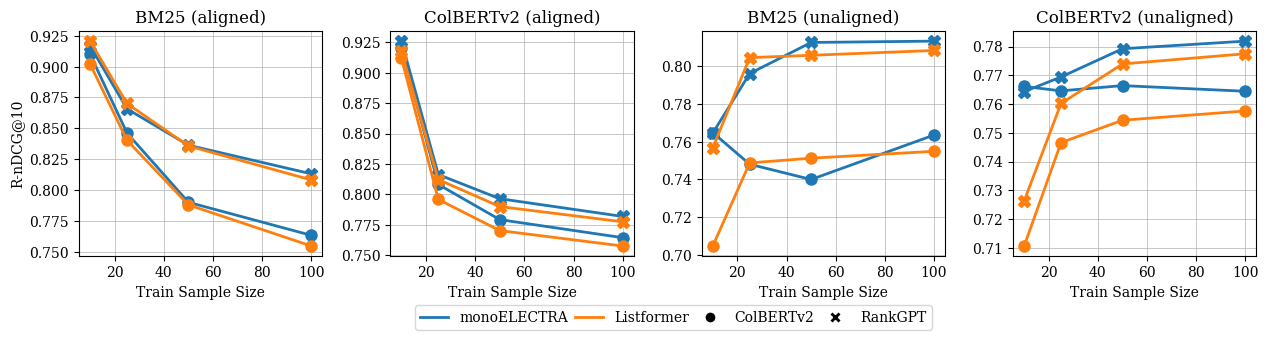

In [69]:
index_columns = [
    "run_type",
    # "num_params",
    "first_train_dataset",
    "second_train_dataset",
    "data.train_sample_size",
    "depth",
    "run_name",
]
values = ["rNDCG@10"]

filter_series = (
    ~base_results["num_params"].isin(["330M"])
    & ~base_results["model.loss_function.class_path"]
    .str.contains("Approx")
    .fillna(False)
    & ~base_results["first_stage"].isin(["tirex"])
    & (
        base_results["first_train_dataset"].isna()
        | base_results["second_train_dataset"].str.contains("ColBERTv2")
    )
    & ~base_results["run_type"].str.contains("Rank")
)

df = (
    base_results.loc[base_results["base"].isin(["msmarco-passage"]) & filter_series]
    .pivot(
        index=index_columns,
        columns=["first_stage"],
        values=values,
    )
    .droplevel(axis=1, level=0)
)

scale = 0.8
fig, axs = plt.subplots(1, 4, figsize=(16 * scale, 4 * scale))
# fig, axs = plt.subplots(1, 2, figsize=(8 * scale, 4 * scale))

for stage_idx, first_stage in enumerate(["bm25", "colbert"]):
    baseline = df.loc[pd.IndexSlice[:, :, :, :, :, first_stage]].dropna(axis=1)
    assert baseline.shape[0] == 1 and baseline.shape[1] == 1
    for model_idx, model in enumerate(("monoELECTRA", "Set-Encoder")):
        for second_idx, second in enumerate(("ColBERTv2", "ColBERTv2 + RankGPT-4.5")):
            model_df = df.loc[pd.IndexSlice[model, :, second], first_stage].copy()
            for aligned_idx, aligned in enumerate((True, False)):
                # for aligned_idx, aligned in enumerate([False]):
                reset = model_df.reset_index()
                if aligned:
                    valid = reset["depth"] == reset["data.train_sample_size"]
                else:
                    valid = reset["depth"] == 100
                plot_df = model_df.loc[valid.values]

                ax_idx = aligned_idx * 2 + stage_idx
                # ax_idx = stage_idx
                ax = axs[ax_idx]

                title = first_stage.replace("bm", "BM").replace("colbert", "ColBERTv2")
                if aligned:
                    title += " (aligned)"
                else:
                    title += " (unaligned)"
                ax.set_title(title)
                ax.set_xlabel("Train Sample Size")
                marker = markers[second_idx]
                color = colors[model_idx]
                if not ax_idx and not (model_idx != second_idx):
                    if "RankGPT-4.5" in second:
                        second_label = "RankGPT"
                    else:
                        second_label = "ColBERTv2"
                    ax.set_ylabel("R-nDCG@10")
                    ax.plot([], [], color=color, label=model, linewidth=2)
                    ax.plot(
                        [],
                        [],
                        color="white",
                        marker=marker,
                        markerfacecolor="black",
                        label=second_label,
                        markersize=8,
                    )

                ax.plot(
                    plot_df.index.get_level_values("data.train_sample_size"),
                    plot_df.values,
                    color=color,
                    marker=marker,
                    markersize=8,
                    linewidth=2,
                )

handles, labels = axs[0].get_legend_handles_labels()
order = [0, 2, 1, 3]
handles = [handles[i] for i in order]
labels = [labels[i] for i in order]
fig.legend(
    handles,
    labels,
    loc="lower center",
    ncol=4,
    bbox_to_anchor=(0.53, -0.07),
    # labelspacing=0.1,
    columnspacing=0.5,
)
fig.tight_layout()
# fig.savefig("train-depth-and-data.pdf", bbox_inches="tight")
plt.show()

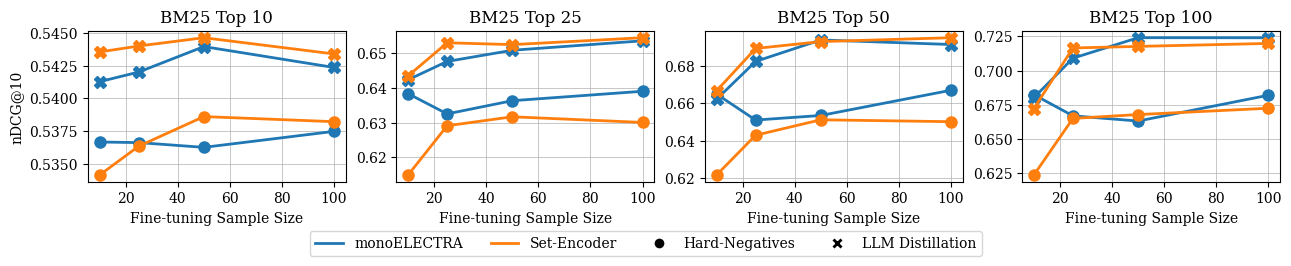

In [14]:
index_columns = [
    "run_type",
    # "num_params",
    "first_train_dataset",
    "second_train_dataset",
    "data.train_sample_size",
    "depth",
    "run_name",
]
values = ["NDCG@10"]

filter_series = (
    ~base_results["num_params"].isin(["340M"])
    & ~base_results["model.loss_function.class_path"]
    .str.contains("Approx")
    .fillna(False)
    & ~base_results["first_stage"].isin(["tirex"])
    & (base_results["second_train_dataset"].isin(["CBv2", "RGPT4-T"]))
    & base_results["run_type"].isin(["monoELECTRA", "Set-Encoder"])
)

df = (
    base_results.loc[base_results["base"].isin(["msmarco-passage"]) & filter_series]
    .pivot(
        index=index_columns,
        columns=["first_stage"],
        values=values,
    )
    .droplevel(axis=1, level=0)
)

scale = 0.8
fig, axs = plt.subplots(
    1,
    4,
    figsize=(16 * scale, 2.8 * scale),
    sharex="col",
    # sharey="row",
    layout="compressed",
)
# fig, axs = plt.subplots(1, 2, figsize=(8 * scale, 4 * scale))

# for stage_idx, first_stage in enumerate(["bm25", "colbert"]):
for stage_idx, first_stage in enumerate(["bm25"]):
    for model_idx, model in enumerate(("monoELECTRA", "Set-Encoder")):
        for second_idx, second in enumerate(("CBv2", "RGPT4-T")):
        # for second_idx, second in enumerate(["ColBERTv2 + RankGPT-4.5"]):
            model_df = df.loc[pd.IndexSlice[model, :, second], first_stage].copy()
            for depth_idx, depth in enumerate((10, 25, 50, 100)):
                # for aligned_idx, aligned in enumerate((True, False)):
                # for aligned_idx, aligned in enumerate([False]):
                reset = model_df.reset_index()
                # if aligned:
                #     valid = reset["depth"] == reset["data.train_sample_size"]
                # else:
                # valid = reset["depth"] == 100
                valid = reset["depth"] == depth
                plot_df = model_df.loc[valid.values]

                # ax_idx = aligned_idx * 2 + stage_idx
                # ax_idx = stage_idx
                ax_idx = depth_idx
                # ax = axs[stage_idx][depth_idx]
                ax = axs[depth_idx]

                title = first_stage.replace("bm", "BM").replace("colbert", "ColBERTv2")
                # if aligned:
                #     title += " (aligned)"
                # else:
                #     title += " (unaligned)"
                title += f" Top {depth}"
                ax.set_title(title)
                # if stage_idx:
                    # ax.set_xlabel("Fine-tuning Sample Size")
                ax.set_xlabel("Fine-tuning Sample Size")
                marker = markers[second_idx]
                color = colors[model_idx]
                if not ax_idx and not (model_idx != second_idx):
                # if not ax_idx:
                    if "RGPT" in second:
                        second_label = "LLM Distillation"
                    else:
                        second_label = "Hard-Negatives"
                    ax.set_ylabel("nDCG@10")
                    ax.plot([], [], color=color, label=model, linewidth=2)
                    ax.plot(
                        [],
                        [],
                        color="white",
                        marker=marker,
                        markerfacecolor="black",
                        label=second_label,
                        markersize=8,
                    )

                ax.plot(
                    plot_df.index.get_level_values("data.train_sample_size"),
                    plot_df.values,
                    color=color,
                    marker=marker,
                    markersize=8,
                    linewidth=2,
                )

# handles, labels = axs[0, 0].get_legend_handles_labels()
handles, labels = axs[0].get_legend_handles_labels()
order = [0, 2, 1, 3]
handles = [handles[i] for i in order]
labels = [labels[i] for i in order]
fig.legend(
    handles,
    labels,
    loc="lower center",
    ncol=4,
    bbox_to_anchor=(0.5, -0.15),
    # labelspacing=0.1,
    # columnspacing=0.5,
)
# fig.tight_layout()
fig.savefig("train-and-inference-depth.pdf", bbox_inches="tight", pad_inches=0, dpi=300)
plt.show()

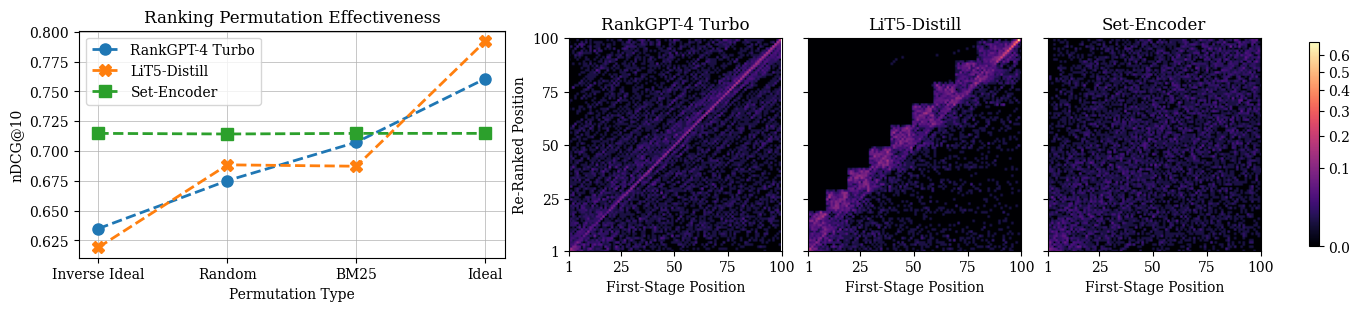

In [64]:
index_columns = [
    "run_type",
    # "run_name",
]
values = ["NDCG@10"]

filter_series = (
    ~base_results["num_params"].isin(["340M"])
    & ~base_results["model.loss_function.class_path"]
    .str.contains("Approx")
    .fillna(False)
    & base_results["first_stage"].isin(
        ["tirex", "bm25-inverse-ideal", "bm25-ideal", "bm25-random"]
    )
    & (
        (base_results["second_train_dataset"].isin(["RGPT4-T"]))
        | (
            base_results["second_train_dataset"].isna()
            & ~base_results["run_type"].isin(["Set-Encoder"])
        )
    )
    & base_results["run_type"].isin(
        [
            "First Stage",
            "Set-Encoder",
            # "Set-Encoder (+Rank)",
            "LiT5-Distill",
            "RankGPT-4 Turbo",
        ]
    )
)

df = (
    base_results.loc[base_results["base"].isin(["msmarco-passage"]) & filter_series]
    .pivot(
        index=index_columns,
        columns=["first_stage"],
        values=values,
    )
    .droplevel(axis=1, level=0)
)

df = df.rename(
    {
        "tirex": "BM25",
        "bm25-ideal": "Ideal",
        "bm25-inverse-ideal": "Inverse Ideal",
        "bm25-random": "Random",
    },
    axis=1,
)
df = df.rename({"First Stage": "BM25"})
models = [
    # "BM25",
    "RankGPT-4 Turbo",
    "LiT5-Distill",
    "Set-Encoder",
    # "Set-Encoder (+Rank)",
]
cases = ["Inverse Ideal", "Random", "BM25", "Ideal"]
df = df.loc[models, cases]

scale = 1.5
fig = plt.figure(figsize=(9 * scale, 2 * scale), layout="constrained")
spec = fig.add_gridspec(1, 5)
ax = fig.add_subplot(spec[0, :2])

x = list(range(4))
for model_idx, model in enumerate(df.index):
    y = df.loc[model]
    ax.plot(
        x,
        y,
        label=model,
        linewidth=2,
        marker=markers[model_idx],
        markersize=8,
        linestyle="dashed",
    )
ax.set_xticks(x)
ax.set_xticklabels(cases)
ax.set_xlabel("Permutation Type")
ax.set_ylabel("nDCG@10")
ax.set_title("Ranking Permutation Effectiveness")
ax.legend()


rank_gpt_turbo_paths = BASELINE_DIR.glob(
    "rank-gpt-4-turbo/tirex_msmarco-passage-trec-dl-*.run"
)
rank_gpt_turbo_run = pd.concat([load_run(path)[0] for path in rank_gpt_turbo_paths])
lit5_paths = BASELINE_DIR.glob(
    "tirex/castorini-list-in-t5-300/msmarco-passage-trec-dl-*.run"
)
lit5_run = pd.concat([load_run(path)[0] for path in lit5_paths])
set_encoder_paths = LOG_DIR.glob(
    "run-20240101_165435-e8bypanb/files/set_encoder/e8bypanb/runs/tirex-rerank_100_msmarco-passage-trec-dl-*.run"
)
set_encoder_run = pd.concat([load_run(path)[0] for path in set_encoder_paths])
tirex_paths = BASELINE_DIR.glob("tirex/bm25/msmarco-passage-trec-dl-*.run")
tirex_run = pd.concat([load_run(path)[0] for path in tirex_paths])

runs = {
    "RankGPT-4 Turbo": rank_gpt_turbo_run,
    "LiT5-Distill": lit5_run,
    "Set-Encoder": set_encoder_run,
}

changes = {}

for run_name, run in runs.items():
    merged = (
        pd.merge(
            run.drop(["Q0", "score", "run_name"], axis=1),
            tirex_run.drop(["Q0", "score", "run_name"], axis=1),
            on=["query_id", "doc_id"],
            how="left",
            suffixes=("_run", "_bm25"),
        )
        .set_index(["query_id", "doc_id"])
        .astype(int)
    )
    rank_changes = (
        merged.groupby("rank_run")
        .value_counts()
        .unstack()
        .fillna(0)
        .astype(int)
        .values
    )
    rank_changes = rank_changes / rank_changes.sum(axis=1, keepdims=True)
    changes[run_name] = rank_changes

vmax = max(change.max() for change in changes.values())
from matplotlib.colors import PowerNorm
norm = PowerNorm(gamma=0.5, vmin=0, vmax=vmax)
axes = []
for idx, (run_name, rank_changes) in enumerate(changes.items()):
    ax = fig.add_subplot(spec[0, idx + 2])
    axes.append(ax)
    ax.set_title(run_name)
    ax.grid(False)
    ax.set_xlabel("First-Stage Position")
    ax.set_xlim(1, 100)
    ax.set_ylim(1, 100)
    ax.set_xticks([1, 25, 50, 75, 100])
    ax.set_yticks([1, 25, 50, 75, 100])
    ax.set_aspect("auto")
    if not idx:
        ax.set_ylabel("Re-Ranked Position")
    else:
        ax.set_yticklabels([])
    im = ax.imshow(rank_changes, norm=norm, cmap="magma", origin="lower")

fig.colorbar(im, ax=axes, shrink=0.9)

fig.savefig("permutation-effectiveness.pdf", bbox_inches="tight", pad_inches=0, dpi=500)

In [12]:
print(df.round(3))

first_stage      Worst Case  Random   BM25  Best Case
run_type                                             
BM25                  0.018   0.209  0.487      0.879
RankGPT-4 Turbo       0.635   0.675  0.707      0.761
LiT5-Distill          0.619   0.688  0.687      0.792
Set-Encoder           0.715   0.714  0.715      0.715
